In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2

In [4]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.file_location import DATA_PATH, ROOT_DIR
from lib.utilities_atlas import  singular_structures, average_shape, mirror_volume_v2

In [5]:
atlas_name = 'atlasV8'
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)

In [51]:
structure = 'SC'
color = 100
volume_origin_list = []
brains = ['MD589', 'MD594', 'MD585']
for brain in brains:
    origin_path = os.path.join(ATLAS_PATH, brain, 'origin')
    volume_path = os.path.join(ATLAS_PATH, brain, 'structure')
    ofilepath = os.path.join(origin_path, f'{structure}.txt')
    vfilepath = os.path.join(volume_path, f'{structure}.npy')
    origin = np.loadtxt(ofilepath)
    volume = np.load(vfilepath)
    volume = volume * color
    volume = volume.astype(np.uint8)
    volume_origin_list.append((volume, origin))
    print(brain, origin, volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

MD589 [698.4370912  278.44011724 128.        ] (104, 157, 182) uint8 0 100 30.886100058687028
MD594 [710.71054997 205.46941101 137.        ] (135, 134, 169) uint8 0 100 30.228378161788036
MD585 [643.08985677 178.83796828 136.        ] (156, 146, 181) uint8 0 100 23.412596762706503


In [52]:
sigma = 5.
volume, origin = average_shape(volume_origin_list=volume_origin_list, force_symmetric=True, sigma=sigma)

In [57]:
volume = np.swapaxes(volume, 0,1)
print(volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

(212, 203, 189) float64 0.0 0.050355446000768994 0.0008054078550571004


In [114]:
scpath = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV8/structure/SC.npy'
sc = np.load(scpath)
#sc = np.rot90(sc, axes=(0, 1))
#sc = np.flip(sc, axis=0)
#sc = sc * color
#sc = sc.astype(np.uint8)
print(sc.shape, sc.dtype, np.amin(sc), np.amax(sc), np.mean(sc))

(170, 162, 191) uint8 0 18 2.373336070903056


In [116]:
#volume = volume.reshape(volume.shape[0], volume.shape[1], volume.shape[2])
arr = sc.copy()
#arr[arr >= 0.1] = color
#arr[arr < color] = 0
#arr = arr.astype(np.uint8)
print('volume shape', arr.shape, arr.dtype, np.unique(arr, return_counts=False))

volume shape (170, 162, 191) uint8 [ 0 18]


Text(0.5, 1.0, ' uint8')

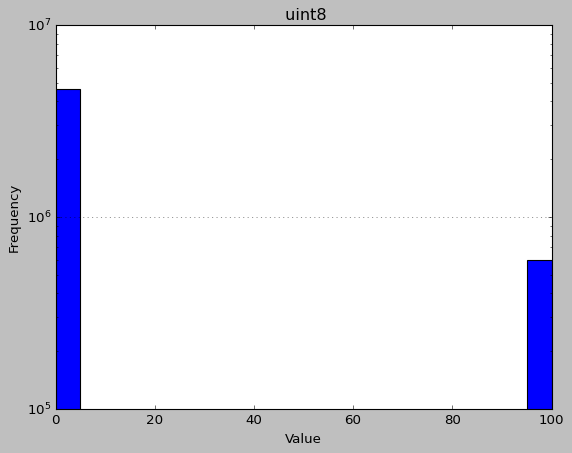

In [115]:
#volume[volume > 0] = 255
#volume[volume < 1] = 0
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

(170, 162, 191)


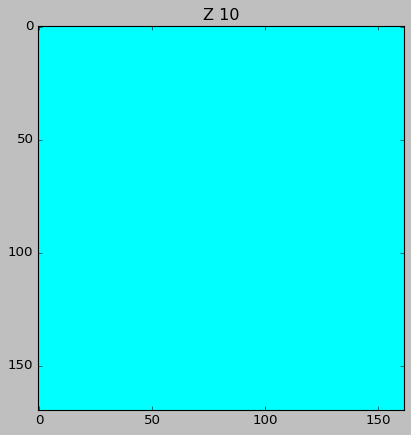

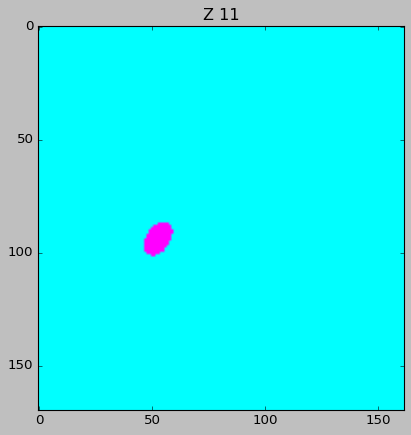

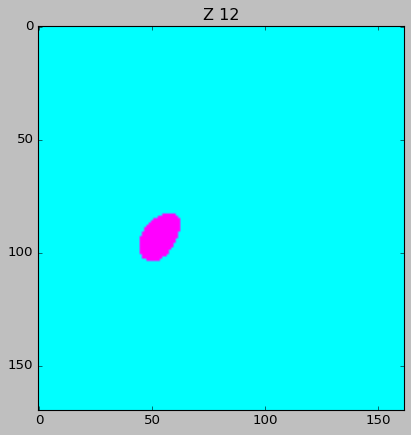

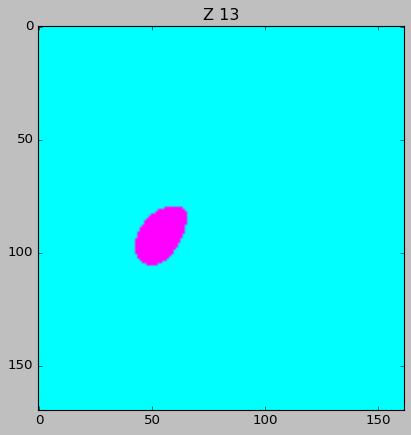

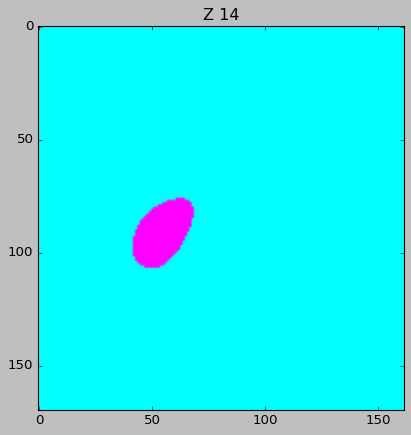

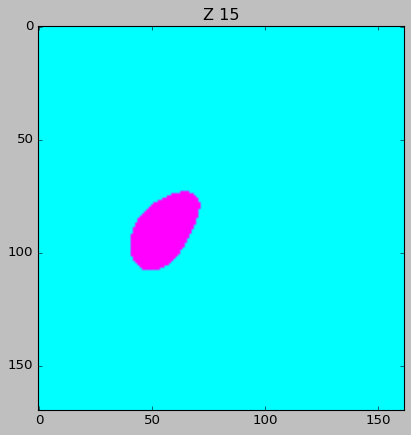

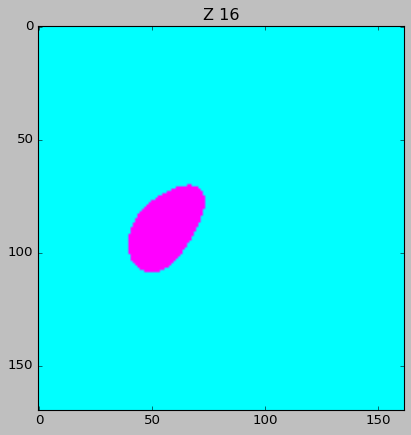

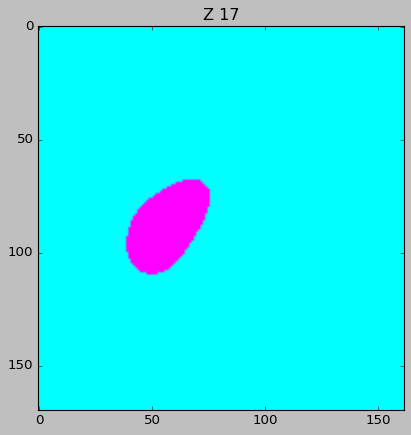

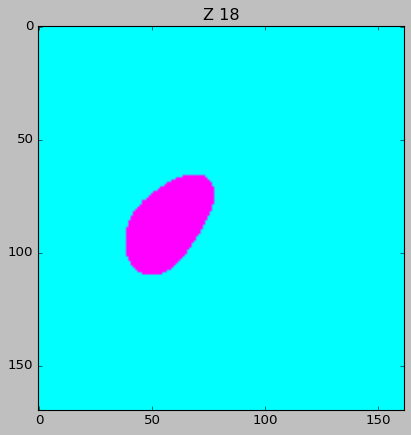

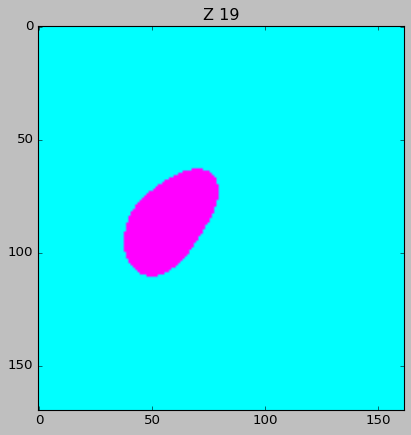

In [117]:
#arr = sc.copy()
#arr = np.rot90(volume, axes=(2, 1))
#arr = np.rot90(arr, 3)
#arr = np.flip(arr, axis=1)    
print(arr.shape)
start = 10
end = start + 10
plt.style.use('classic')
for i in range(start, end,1):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [ ]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[1000,1000,1000])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

In [ ]:
files